In [1]:
import tensorflow as tf 
import keras 
import keras.backend as K

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from collections import Counter

from keras import regularizers
from keras.models import Sequential, Model, load_model, model_from_json 
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Reshape, Concatenate,  Dropout 
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.layers.advanced_activations import LeakyReLU

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt


def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True, combine_grav_acc=False):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.
        combine_grav_acc: True, means adding each axis of gravity to  corresponding axis of userAcceleration.
    Returns: 
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                
                if combine_grav_acc:
                    raw_data["userAcceleration.x"] = raw_data["userAcceleration.x"].add(raw_data["gravity.x"])
                    raw_data["userAcceleration.y"] = raw_data["userAcceleration.y"].add(raw_data["gravity.y"])
                    raw_data["userAcceleration.z"] = raw_data["userAcceleration.z"].add(raw_data["gravity.z"])
                
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________
#________________________________

def ts_to_secs(dataset, w, s, standardize = False, **options):
    
    data = dataset[dataset.columns[:-7]].values    
    act_labels = dataset["act"].values
    id_labels = dataset["id"].values
    trial_labels = dataset["trial"].values

    mean = 0
    std = 1
    if standardize:
        ## Standardize each sensor’s data to have a zero mean and unity standard deviation.
        ## As usual, we normalize test dataset by training dataset's parameters 
        if options:
            mean = options.get("mean")
            std = options.get("std")
            print("[INFO] -- Test Data has been standardized")
        else:
            mean = data.mean(axis=0)
            std = data.std(axis=0)
            print("[INFO] -- Training Data has been standardized: the mean is = "+str(mean)+" ; and the std is = "+str(std))            

        data -= mean
        data /= std
    else:
        print("[INFO] -- Without Standardization.....")

    ## We want the Rows of matrices show each Feature and the Columns show time points.
    data = data.T

    m = data.shape[0]   # Data Dimension 
    ttp = data.shape[1] # Total Time Points
    number_of_secs = int(round(((ttp - w)/s)))

    ##  Create a 3D matrix for Storing Sections  
    secs_data = np.zeros((number_of_secs , m , w ))
    act_secs_labels = np.zeros(number_of_secs)
    id_secs_labels = np.zeros(number_of_secs)

    k=0
    for i in range(0 , ttp-w, s):
        j = i // s
        if j >= number_of_secs:
            break
        if id_labels[i] != id_labels[i+w-1]: 
            continue
        if act_labels[i] != act_labels[i+w-1]: 
            continue
        if trial_labels[i] != trial_labels[i+w-1]:
            continue
            
        secs_data[k] = data[:, i:i+w]
        act_secs_labels[k] = act_labels[i].astype(int)
        id_secs_labels[k] = id_labels[i].astype(int)
        k = k+1
        
    secs_data = secs_data[0:k]
    act_secs_labels = act_secs_labels[0:k]
    id_secs_labels = id_secs_labels[0:k]
    return secs_data, act_secs_labels, id_secs_labels, mean, std
##________________________________________________________________


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[2,11],
    ACT_LABELS[1]:[4,12],
    ACT_LABELS[2]:[7,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13],
}

# ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
# TRIAL_CODES = {
#     ACT_LABELS[0]:[1,2,11],
#     ACT_LABELS[1]:[3,4,12],
#     ACT_LABELS[2]:[7,8,15],
#     ACT_LABELS[3]:[9,16],
#     ACT_LABELS[4]:[6,14],
#     ACT_LABELS[5]:[5,13],
# }

In [3]:
## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["rotationRate", "userAcceleration"]
mode = "mag"
ep = 100
cga = True # Add gravity to acceleration or not

print("[INFO] -- Selected sensor data types: "+str(sdt)+" -- Mode: "+str(mode)+" -- Grav+Acc: "+str(cga))    
act_labels = ACT_LABELS [0:4]

print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode=mode, labeled=True, combine_grav_acc = cga)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    


#*****************
TRAIN_TEST_TYPE = "trial" # "subject" or "trial"
#*****************

if TRAIN_TEST_TYPE == "subject":
    test_ids = [4,9,11,21]
    print("[INFO] -- Test IDs: "+str(test_ids))
    test_ts = dataset.loc[(dataset['id'].isin(test_ids))]
    train_ts = dataset.loc[~(dataset['id'].isin(test_ids))]
else:
    test_trail = [11,12,13,14,15,16]  
    print("[INFO] -- Test Trials: "+str(test_trail))
    test_ts = dataset.loc[(dataset['trial'].isin(test_trail))]
    train_ts = dataset.loc[~(dataset['trial'].isin(test_trail))]

print("[INFO] -- Shape of Train Time-Series :"+str(train_ts.shape))
print("[INFO] -- Shape of Test Time-Series :"+str(test_ts.shape))

print(train_ts.head())

[INFO] -- Selected sensor data types: ['rotationRate', 'userAcceleration'] -- Mode: mag -- Grav+Acc: True
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(538839, 9)
[INFO] -- Test Trials: [11, 12, 13, 14, 15, 16]
[INFO] -- Shape of Train Time-Series :(393152, 9)
[INFO] -- Shape of Test Time-Series :(145687, 9)
   rotationRate  userAcceleration  act   id  weight  height   age  gender  \
0      1.934974          0.848353  0.0  0.0   102.0   188.0  46.0     1.0   
1      0.948655          0.845879  0.0  0.0   102.0   188.0  46.0     1.0   
2      1.558111          0.650129  0.0  0.0   102.0   188.0  46.0     1.0   
3      2.549060          0.694418  0.0  0.0   102.0   188.0  46.0     1.0   
4      3.006681          0.652475  0.0  0.0   102.0   188.0  46.0     1.0   

   trial  
0    2.0  
1    2.0  
2    2.0  
3    2.0  
4    2.0  


In [4]:
## This Variable Defines the Size of Sliding Window
## ( e.g. 100 means in each snapshot we just consider 100 consecutive observations of each sensor) 
w = 64 # 50 Equals to 1 second for MotionSense Dataset (it is on 50Hz samplig rate)
## Here We Choose Step Size for Building Diffrent Snapshots from Time-Series Data
## ( smaller step size will increase the amount of the instances and higher computational cost may be incurred )
s = 16
train_data, act_train, id_train, train_mean, train_std = ts_to_secs(train_ts.copy(),
                                                                   w,
                                                                   s,
                                                                   standardize = True)

s = 16
test_data, act_test, id_test, test_mean, test_std = ts_to_secs(test_ts.copy(),
                                                              w,
                                                              s,
                                                              standardize = True,
                                                              mean = train_mean, 
                                                              std = train_std)

print("[INFO] -- Shape of Training Sections: "+str(train_data.shape))
print("[INFO] -- Shape of Test Sections:  "+str(test_data.shape))


id_train_labels = to_categorical(id_train)
id_test_labels = to_categorical(id_test)
act_train_labels = to_categorical(act_train)
act_test_labels = to_categorical(act_test)
## Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
train_data = np.expand_dims(train_data,axis=3)
print("[INFO] -- Shape of Training Sections:", train_data.shape)
test_data = np.expand_dims(test_data,axis=3)
print("[INFO] -- Shape of Training Sections:", test_data.shape)

height = train_data.shape[1]
width = train_data.shape[2]

id_class_numbers = 24
act_class_numbers = len(np.unique(act_train))

[INFO] -- Training Data has been standardized: the mean is = [2.34393788 1.24353595] ; and the std is = [1.53834876 0.77958712]
[INFO] -- Test Data has been standardized
[INFO] -- Shape of Training Sections: (24195, 2, 64)
[INFO] -- Shape of Test Sections:  (8729, 2, 64)
[INFO] -- Shape of Training Sections: (24195, 2, 64, 1)
[INFO] -- Shape of Training Sections: (8729, 2, 64, 1)


In [5]:
class Encoder:
    l2p = 0.0005
    @staticmethod
    def layers(x, fm, act_func="linear", hid_act_func="relu"):
        x = Conv2D(32, fm, activation=hid_act_func, kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)

        
        x = Conv2D(32, fm, activation=hid_act_func, kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)
        
        x = Conv2D(32, fm, activation=hid_act_func, kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)

        
        x = Conv2D(32, fm, activation=hid_act_func,kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)
        
        x = Conv2D(32, fm, activation=hid_act_func,kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)

        x = Conv2D(1, fm, activation=act_func, padding='same')(x) 
        y = BatchNormalization()(x)

        return y
   
    @staticmethod
    def build(height, width, fm, act_func="linear", hid_act_func="relu"):
        inp = Input(shape=(height, width,1))
        enc = Encoder.layers(inp, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=enc ,name="Encoder")
        return model

class Decoder:
    l2p = 0.0005
    @staticmethod
    def layers(y, height, width, fm, act_func="linear", hid_act_func="relu"):
        
        x = Conv2DTranspose(32, fm, strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(y)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(32, fm,  strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(32, fm,  strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(32, fm,  strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(32, fm, strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        
        xh = Conv2D(1, fm, activation=act_func, padding='same')(x)
        return xh
   
    @staticmethod
    def build(height, width, fm , act_func="linear", hid_act_func="relu"):
        inp = Input(shape=(height, width,1))
        dec  = Decoder.layers(inp,height, width, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=dec ,name="Decoder")
        return model

In [6]:
fm = (2,5)
enc = Encoder.build(height, width, fm, act_func="linear", hid_act_func="relu")
dec = Decoder.build(height, width//32, fm, act_func="linear", hid_act_func="relu")
enc.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])
dec.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])
inp = Input(shape=(height, width,1))
x = enc(inp)
z = dec(x)
cae = Model(inputs=inp, outputs=z)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
filepath="msda_64_to_2_cae.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, early_stop]

cae.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])

cae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2, 64, 1)          0         
_________________________________________________________________
Encoder (Model)              (None, 2, 2, 1)           42405     
_________________________________________________________________
Decoder (Model)              (None, 2, 64, 1)          42401     
Total params: 84,806
Trainable params: 84,164
Non-trainable params: 642
_________________________________________________________________


In [7]:
lm_file = "msda_anon_model"

json_file = open(lm_file+".json", 'r')
loaded_model_json = json_file.read()
json_file.close()
anon_model = model_from_json(loaded_model_json)
anon_model.load_weights(lm_file+"_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [8]:
X = train_data.copy()
T = test_data.copy()

In [9]:
for i in np.arange(0,len(train_data)-2,2):
    train_tmp = np.expand_dims(np.append(train_data[i], train_data[i+1], axis=1), axis=0)
    train_tmp = anon_model.predict(train_tmp)[0]
    X[i,:,:64,0] = train_tmp[0,:,:64,0]
    X[i+1,:,:64,0] = train_tmp[0,:,64:,0]
for i in np.arange(0,len(test_data)-2,2):    
    test_tmp = np.expand_dims(np.append(test_data[i], test_data[i+1], axis=1), axis=0)
    test_tmp = anon_model.predict(test_tmp)[0]
    T[i,:,:64,0] = test_tmp[0,:,:64,0]
    T[i+1,:,:64,0] = test_tmp[0,:,64:,0]

In [10]:
cae.fit(X, X,
        validation_data = (T, T),
        epochs = ep,
        batch_size = 128,
        verbose = 0,
        callbacks = callbacks_list
       )

cae.load_weights("msda_64_to_2_cae.best.hdf5")
cae.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])


Epoch 00001: val_loss improved from inf to 0.43516, saving model to msda_64_to_2_cae.best.hdf5

Epoch 00002: val_loss improved from 0.43516 to 0.37000, saving model to msda_64_to_2_cae.best.hdf5

Epoch 00003: val_loss improved from 0.37000 to 0.34346, saving model to msda_64_to_2_cae.best.hdf5

Epoch 00004: val_loss did not improve from 0.34346

Epoch 00005: val_loss improved from 0.34346 to 0.29090, saving model to msda_64_to_2_cae.best.hdf5

Epoch 00006: val_loss did not improve from 0.29090

Epoch 00007: val_loss improved from 0.29090 to 0.26853, saving model to msda_64_to_2_cae.best.hdf5

Epoch 00008: val_loss improved from 0.26853 to 0.25398, saving model to msda_64_to_2_cae.best.hdf5

Epoch 00009: val_loss did not improve from 0.25398

Epoch 00010: val_loss did not improve from 0.25398

Epoch 00011: val_loss improved from 0.25398 to 0.24957, saving model to msda_64_to_2_cae.best.hdf5

Epoch 00012: val_loss improved from 0.24957 to 0.23677, saving model to msda_64_to_2_cae.best.h

In [12]:
lv_y_train = enc.predict(train_data)
lv_y_test  = enc.predict(test_data)

print("[INFO] -- Shape tz_train:"+str(lv_y_train.shape))
print("[INFO] --  Shape tz_test :"+str(lv_y_test.shape))

[INFO] -- Shape tz_train:(24195, 2, 2, 1)
[INFO] --  Shape tz_test :(8729, 2, 2, 1)


In [13]:
lv_y_train_flat = lv_y_train.reshape(lv_y_train.shape[0], lv_y_train.shape[1], lv_y_train.shape[2]*lv_y_train.shape[3])
lv_y_test_flat = lv_y_test.reshape(lv_y_test.shape[0], lv_y_test.shape[1], lv_y_test.shape[2]*lv_y_test.shape[3])
print("[INFO] -- Shape tz_train:"+str(lv_y_train_flat.shape))
print("[INFO] --  Shape tz_test :"+str(lv_y_test_flat.shape))

[INFO] -- Shape tz_train:(24195, 2, 2)
[INFO] --  Shape tz_test :(8729, 2, 2)


In [14]:
x_2d_train = lv_y_train_flat[:,0,:]
x_2d_test = lv_y_test_flat[:,0,:]

Text(0.04,0.5,'second component of Y')

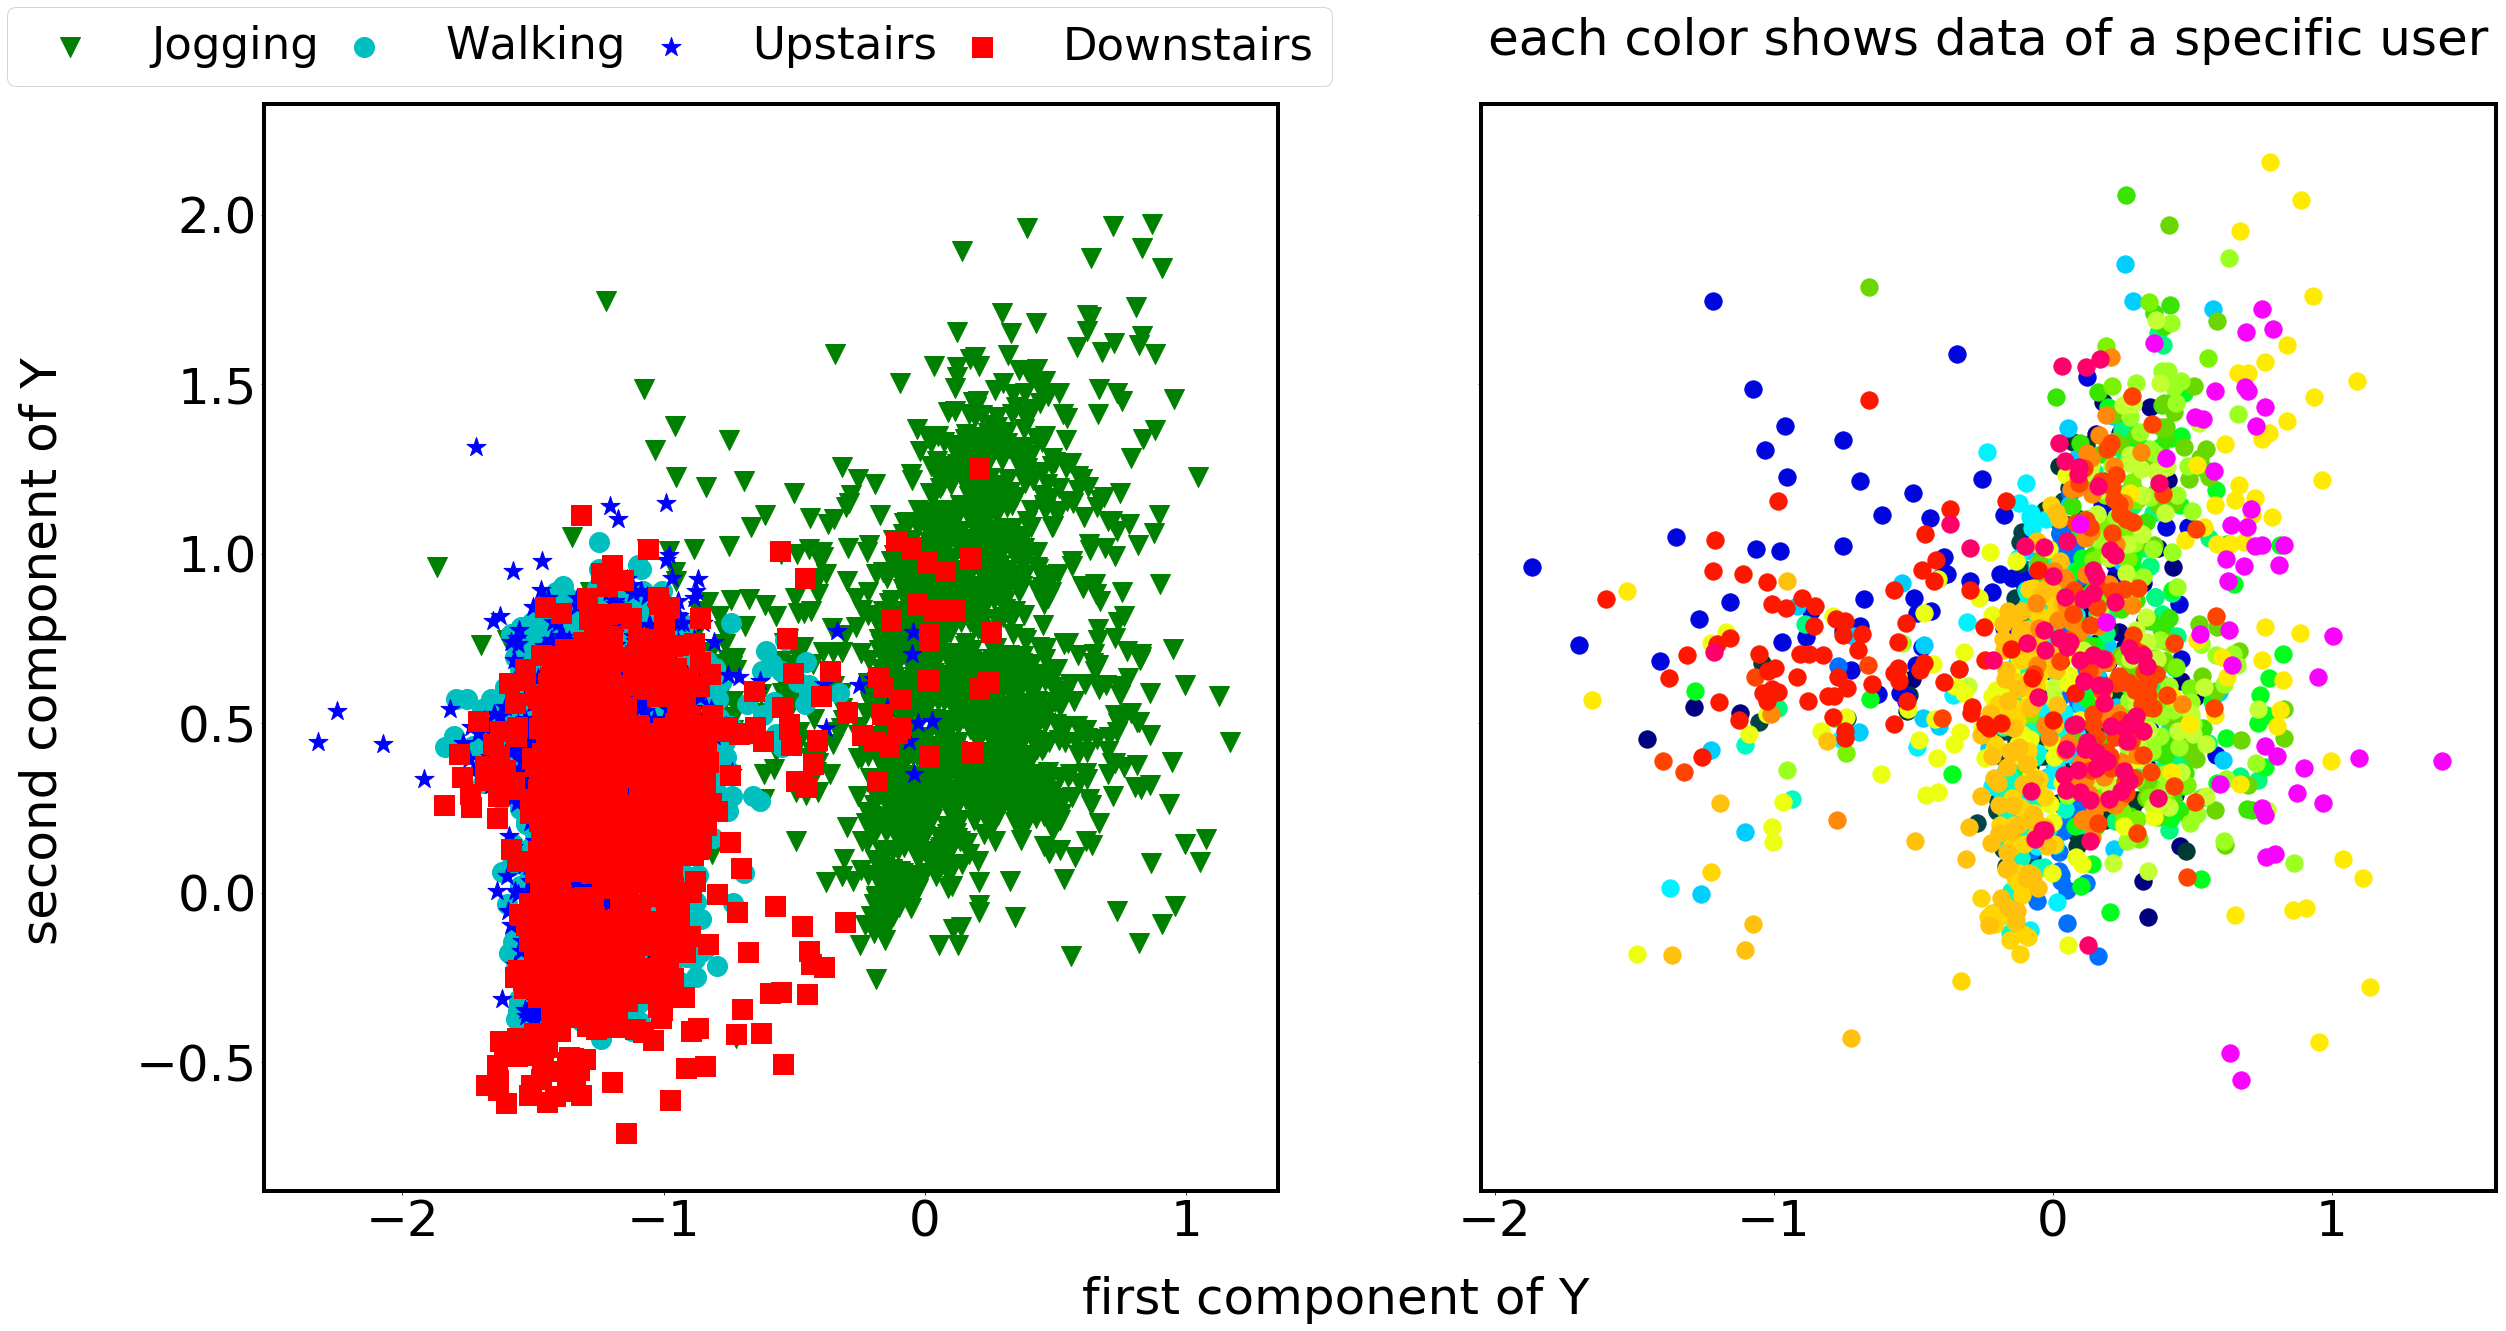

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap

plt.rcParams['figure.figsize'] = (40,20)
plt.rcParams['font.size'] = 50
plt.rcParams['axes.linewidth'] = 4

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')


colors = ['r','b','c','g','k','m']
classes = ["Downstairs","Upstairs", "Walking", "Jogging", "Stand-Up", "Sat"]
markers = ["s", "*", "o", "v", "p", "^"]
for i in [3,2,1,0]:
    x = ((x_2d_train[act_train == i])[:,0])[::4]
    y = ((x_2d_train[act_train == i])[:,1])[::4]
    ax[0].scatter(x, y, c=colors[i], label=classes[i], marker = markers[i], alpha=1.0, s = 400)
ax[0].legend(bbox_to_anchor=(-0.275, 1.01, 1.35, .1), mode="expand",ncol=4, fontsize=45)    
#plt.xlabel("t-SNE component 1 (normalized uints)",fontsize = 45)
#plt.ylabel("t-SNE component 2 (normalized uints)",fontsize = 45)

n = 30
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0., 1.01, 1./(n-1.))]

act = 3

for i in range(24):
    x = ((x_2d_train[np.logical_and(id_train == i, act_train == act)])[:,0])[::4]
    y = ((x_2d_train[np.logical_and(id_train == i, act_train == act)])[:,1])[::4]
    ax[1].scatter(x, y, c=colors[i], label="u_"+str(i+1), alpha=1., s = 300)
ax[1].set_title("each color shows data of a specific user", y=1.04, fontsize=50)
# plt.xlabel("t-SNE component 1 (normalized uints)")
# plt.ylabel("t-SNE component 2 (normalized uints)")
fig.text(0.5, 0.04, 'first component of Y ', ha='center',fontsize=50)
fig.text(0.04, 0.5, 'second component of Y', va='center', rotation='vertical', fontsize=50)
